In [0]:
def split(img):
  img=img
  # labels.append(label)
  #print(img.shape)
  n,c,h,w=img.shape
  # print(len(img))
  #print(img.shape)
  left_lung=img[:,:,0:h,0:int(w/2)]
  right_lung=img[:,:,0:h,int(w/2):w]
  #print(left_lung.shape)
  #print(right_lung.shape)             
  #trans1=transforms.ToTensor()
  #left_lung=trans1(left_lung)
  #right_lung=trans1(right_lung)
  # left_lung=pad_to_square(left_lung)
  # right_lung=pad_to_square(right_lung)
  # #print(left_lung.shape)
  # #print(right_lung.shape)
  # train_left.append(left_lung)
  # train_right.append(right_lung)
  # print(left_lung.shape)
  return left_lung, right_lung

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
pathimg='/content/drive/My Drive/cropped_images_new/'
image_path=os.listdir(pathimg)

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize = transforms.Normalize([0.5742, 0.5745, 0.5749], [0.1908, 0.1907, 0.1906])
transform = transforms.Compose([
    # transforms.RandomResizedCrop((448,224)),   #left, top, right, bottom
    # transforms.Resize((448,224)),
    transforms.Resize((448,448)),
    transforms.ToTensor(),
    normalize
])
for files in image_path:
  img=Image.open(pathimg + files).convert('RGB')
  # print(np.array(img))
  print("######")

  # img1=np.array(img)/255
  # img1=torch.tensor(img)
  newimg=transform(img)
  # print(newimg.shape)
  # left,right=split(newimg)
  # print(img1)
  # plt.imshow(newimg)
  plt.imshow(newimg.permute(1, 2, 0))
  plt.show()
  

In [0]:
from DatasetGenerator import DatasetGenerator
from torch.utils.data import Dataset, DataLoader
import torch
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for i, (images, labels) in enumerate(loader):

        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

   
transform = transforms.Compose([
    # transforms.RandomResizedCrop((448,224)),   #left, top, right, bottom
    transforms.Resize((448,224)),
    transforms.ToTensor()
    # normalize
])
pathDirData='/content/drive/My Drive/'
dataset = DatasetGenerator(pathImageDirectory=pathDirData, transform=transform)
loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False
)

mean, std = online_mean_and_sd(loader)

print("mean: ",mean)
print("std: ",std)

mean:  tensor([0.5742, 0.5745, 0.5749])
std:  tensor([0.1908, 0.1907, 0.1906])


In [0]:
import torch.nn.functional as F
def pad_to_square(img, pad_value=0):
    n,c,h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)
    return img

In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import cv2
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from DatasetGenerator import DatasetGenerator
# from model.residual_attention_network_pre import ResidualAttentionModel
# based https://github.com/liudaizong/Residual-Attention-Network
from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel

model_file = '/content/model_448_sgd_full_lungs_normalise4.pkl'


# for test
def test(model, test_loader, btrain=False, model_file=model_file):
    # Test
    if not btrain:
        model.load_state_dict(torch.load(model_file))
    model.eval()

    correct = 0
    total = 0
    #
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    for images, labels in test_loader:
        # left,right=split(images)
        # left = Variable(left.cuda())
        # labels = Variable(labels.cuda())
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        #
        c = (predicted == labels.data).squeeze()
        # print(labels)
        # print(c.shape)
        # print(c)
        xyz=c.to('cpu').numpy()
        # print("xyz: " ,xyz[2])
        for i in range(2):
            label = labels.data[i]
            # print(c[i])
            # abc=c[i][0]
            class_correct[label] += xyz[i]
            class_total[label] += 1
        #     print(xyz[i])
        #     print("class_correct: ",class_correct)
        # print("batch end")

    print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
    print('Accuracy of the model on the test images:', float(correct)/total)
    for i in range(2):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    return 100*correct / total


# Image Preprocessing
pathDirData='/content/drive/My Drive/'
pathDirDatatest='/content/drive/My Drive/test/'
# normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize = transforms.Normalize([0.5742, 0.5745, 0.5749], [0.1908, 0.1907, 0.1906])
transform = transforms.Compose([
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomHorizontalFlip(),
    # transforms.Resize((224,448)),   #left, top, right, bottom
    transforms.Resize((448,448)),
    # transforms.Scale(224),
    transforms.ToTensor()
    # normalize
])
test_transform = transforms.Compose([
    # transforms.Resize((224,448)),
    transforms.Resize((448,448)),                                  
    transforms.ToTensor()
    # normalize
])
# when image is rgb, totensor do the division 255

train_dataset = DatasetGenerator(pathImageDirectory=pathDirData, transform=transform)

test_dataset = DatasetGenerator(pathImageDirectory=pathDirDatatest, transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=6, # 64
                                           shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=2,
                                          shuffle=True)

classes = ('no Roi','Roi')
model = ResidualAttentionModel().cuda()
# print(model)

lr = 3.000002e-04  # 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.7, nesterov=True, weight_decay=0.0001)
# optimizer = optim.Adam (model.parameters(), lr=lr, betas=(0.8, 0.999), eps=1e-08, weight_decay=0.0001)
# scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 4, mode = 'min')
is_train = True
is_pretrain = True
acc_best = 0
total_epoch = 30
if is_train is True:
    if is_pretrain == True:
        model.load_state_dict((torch.load(model_file)))
    # Training
    for epoch in range(total_epoch):
        model.train()
        tims = time.time()
        lossavg=0
        tot=0
        for i, (images, labels) in enumerate(train_loader):
            # print(images.shape)
            # left,right=split(images)
            # print(left.shape)
            images = Variable(images.cuda())
            # left = Variable(left.cuda())
            # print(images.data)
            # print(labels)
            labels = Variable(labels.cuda())

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print("hello")
            lossavg +=loss.item()
            tot+=1
            
            # if (i+1) % 10 == 0:
                # print("Epoch [%d/%d], Iter [%d/%d] Loss: %.4f" %(epoch+1, total_epoch, i+1, len(train_loader), loss.item()))
        
        aver=lossavg/tot
        print(" ")
        print(" ")
        print(" ")
        print('the epoch takes time:',time.time()-tims)
        print("Epoch [%d/%d],  AVERAGELoss: %.4f" %(epoch+1,total_epoch,aver))
        print('evaluate test set:')
        acc = test(model, test_loader, btrain=True)
        # print("acc",acc)
        # print(acc_best)
        if acc > acc_best:
            acc_best = acc
            print('current best acc,', acc_best)
            torch.save(model.state_dict(), "/content/model_448_sgd_full_lungs_normalise3.pkl")
        # Decaying Learning Rate
        if (epoch+1) / float(total_epoch) == 0.3 or (epoch+1) / float(total_epoch) == 0.6 or (epoch+1) / float(total_epoch) == 0.9:
            lr /= 10
            print('reset learning rate to:', lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                print(param_group['lr'])
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
    # Save the Model
    torch.save(model.state_dict(), 'last_model_448_sgd_full_lungs.pkl')

else:
    test(model, test_loader, btrain=False)



 
 
 
the epoch takes time: 51.39883875846863
Epoch [1/30],  AVERAGELoss: 0.1038
evaluate test set:
Accuracy of the model on the test images: 75 %
Accuracy of the model on the test images: 0.75
Accuracy of no Roi : 80 %
Accuracy of   Roi : 71 %
current best acc, tensor(75, device='cuda:0')
 
 
 
the epoch takes time: 51.767815589904785
Epoch [2/30],  AVERAGELoss: 0.1332
evaluate test set:
Accuracy of the model on the test images: 81 %
Accuracy of the model on the test images: 0.8125
Accuracy of no Roi : 80 %
Accuracy of   Roi : 82 %
current best acc, tensor(81, device='cuda:0')
 
 
 
the epoch takes time: 51.895832538604736
Epoch [3/30],  AVERAGELoss: 0.1208
evaluate test set:
Accuracy of the model on the test images: 75 %
Accuracy of the model on the test images: 0.75
Accuracy of no Roi : 80 %
Accuracy of   Roi : 71 %
 
 
 
the epoch takes time: 51.81701970100403
Epoch [4/30],  AVERAGELoss: 0.1111
evaluate test set:
Accuracy of the model on the test images: 77 %
Accuracy of the model 

In [0]:
############Right lung

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import cv2
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from DatasetGenerator import DatasetGenerator
# from model.residual_attention_network_pre import ResidualAttentionModel
# based https://github.com/liudaizong/Residual-Attention-Network
from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel

model_file = './model_92_sgd2_left.pkl'


# for test
def test(model, test_loader, btrain=False, model_file=model_file):
    # Test
    if not btrain:
        model.load_state_dict(torch.load(model_file))
    model.eval()

    correct = 0
    total = 0
    #
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    for images, labels in test_loader:
        left,right=split(images)
        left = Variable(left.cuda())
        labels = Variable(labels.cuda())
        outputs = model(left)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        #
        c = (predicted == labels.data).squeeze()
        # print(labels)
        # print(c.shape)
        # print(c)
        xyz=c.to('cpu').numpy()
        # print("xyz: " ,xyz[2])
        
        for i in range(2):
            label = labels.data[i]
            # print(c[i])
            # abc=c[i][0]
            class_correct[label] += xyz[i]
            class_total[label] += 1
        #     print(xyz[i])
        #     print("class_correct: ",class_correct)
        # print("batch end")

    print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
    print('Accuracy of the model on the test images:', float(correct)/total)
    for i in range(2):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    return 100*correct / total


# Image Preprocessing
pathDirData='/content/drive/My Drive/'
pathDirDataTest='/content/drive/My Drive/test/'
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize = transforms.Normalize([0.5742, 0.5745, 0.5749], [0.1908, 0.1907, 0.1906])
transform = transforms.Compose([
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomHorizontalFlip(),
    transforms.Resize((448,896)),   #left, top, right, bottom
    # transforms.Scale(224),
    transforms.ToTensor(),
    normalize
])
test_transform = transforms.Compose([
    transforms.Resize((448,896)),                                  
    transforms.ToTensor(),
    normalize
])
# when image is rgb, totensor do the division 255

train_dataset = DatasetGenerator(pathImageDirectory=pathDirData, transform=transform)

test_dataset = DatasetGenerator(pathImageDirectory=pathDirDataTest, transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=6, # 64
                                           shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=2,
                                          shuffle=True)

classes = ('no Roi','Roi')
model = ResidualAttentionModel().cuda()
# print(model)

lr = 1.000002e-04  # 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
# optimizer = optim.Adam (model.parameters(), lr=lr, betas=(0.8, 0.999), eps=1e-08, weight_decay=0.0001)
# scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 4, mode = 'min')
is_train = True
is_pretrain = False
acc_best = 0
total_epoch = 50
if is_train is True:
    if is_pretrain == True:
        model.load_state_dict((torch.load(model_file)))
    # Training
    for epoch in range(total_epoch):
        model.train()
        tims = time.time()
        lossavg=0
        tot=0
        for i, (images, labels) in enumerate(train_loader):
            left,right= split(images)
            left = Variable(left.cuda())
            # print(images.data)
            # print(labels)
            labels = Variable(labels.cuda())

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(left)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print("hello")
            lossavg +=loss.item()
            tot+=1
            # if (i+1) % 10 == 0:
                # print("Epoch [%d/%d], Iter [%d/%d] Loss: %.4f" %(epoch+1, total_epoch, i+1, len(train_loader), loss.item()))
        aver=lossavg/tot
        print(" ")
        print(" ")
        print(" ")
        print('the epoch takes time:',time.time()-tims)
        print("Epoch [%d/%d],  AVERAGELoss: %.4f" %(epoch+1,total_epoch,aver))
        print('evaluate test set:')
        acc = test(model, test_loader, btrain=True)
        # print("acc",acc)
        # print(acc_best)
        if acc > acc_best:
            acc_best = acc
            print('current best acc,', acc_best)
            torch.save(model.state_dict(), model_file)
        # Decaying Learning Rate
        if (epoch+1) / float(total_epoch) == 0.3 or (epoch+1) / float(total_epoch) == 0.6 or (epoch+1) / float(total_epoch) == 0.9:
            lr /= 10
            print('reset learning rate to:', lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                print(param_group['lr'])
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
    # Save the Model
    torch.save(model.state_dict(), 'last_model_92_sgd2_left.pkl')

else:
    test(model, test_loader, btrain=False)



KeyboardInterrupt: ignored

In [0]:
####concat

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import cv2
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from DatasetGenerator import DatasetGenerator
# from model.residual_attention_network_pre import ResidualAttentionModel
# based https://github.com/liudaizong/Residual-Attention-Network
# from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel
from residual_attention_network import ResidualAttentionModel_448concat as ResidualAttentionModelconcat

model_file = '/content/model_92_sgdconcattest1.pkl'


# for test
def test(model, test_loader, btrain=False, model_file=model_file):
    # Test
    if not btrain:
        model.load_state_dict(torch.load(model_file))
    model.eval()

    correct = 0
    total = 0
    #
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    for images, labels in test_loader:
        left,right=split(images)
        left = Variable(left.cuda())
        right = Variable(right.cuda())
        labels = Variable(labels.cuda())
        outputs = model(left,right)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        #
        c = (predicted == labels.data).squeeze()
        # print(labels)
        # print(c.shape)
        # print(c)
        xyz=c.to('cpu').numpy()
        # print("xyz: " ,xyz[2])
        
        for i in range(3):
            label = labels.data[i]
            # print(c[i])
            # abc=c[i][0]
            class_correct[label] += xyz[i]
            class_total[label] += 1
        #     print(xyz[i])
        #     print("class_correct: ",class_correct)
        # print("batch end")

    print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
    print('Accuracy of the model on the test images:', float(correct)/total)
    for i in range(2):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    return 100*correct / total


# Image Preprocessing
pathDirData='/content/drive/My Drive/publicbatch/'
pathDirDataTest='/content/drive/My Drive/batch1_crop/'
# normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
normalize = transforms.Normalize([0.5742, 0.5745, 0.5749], [0.1908, 0.1907, 0.1906])
transform = transforms.Compose([
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomHorizontalFlip(),
    transforms.Resize((448,896)),   #left, top, right, bottom
    # transforms.Scale(224),
    transforms.ToTensor()
    # normalize
])
test_transform = transforms.Compose([
    transforms.Resize((448,896)),                                  
    transforms.ToTensor()
    # normalize
])
# when image is rgb, totensor do the division 255

train_dataset = DatasetGenerator(pathImageDirectory=pathDirData, transform=transform)

test_dataset = DatasetGenerator(pathImageDirectory=pathDirDataTest, transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=6, # 64
                                           shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=3,
                                          shuffle=True)

classes = ('no Roi','Roi')
model = ResidualAttentionModelconcat().cuda()
# print(model)

lr = 3.00000002e-03 # 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8, nesterov=True, weight_decay=0.0003)
# optimizer = optim.Adam (model.parameters(), lr=lr, betas=(0.8, 0.999), eps=1e-08, weight_decay=0.0001)
# scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 4, mode = 'min')
is_train = True
is_pretrain = False
acc_best = 0
total_epoch = 40
if is_train is True:
    if is_pretrain == True:
        model.load_state_dict((torch.load(model_file)))
    # Training
    for epoch in range(total_epoch):
        model.train()
        tims = time.time()
        lossavg=0
        tot=0
        for i, (images, labels) in enumerate(train_loader):
            left,right= split(images)
            left = Variable(left.cuda())
            right = Variable(right.cuda())
            # print(images.data)
            # print(labels)
            labels = Variable(labels.cuda())

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(left,right)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print("hello")
            lossavg +=loss.item()
            tot+=1
            # if (i+1) % 10 == 0:
                # print("Epoch [%d/%d], Iter [%d/%d] Loss: %.4f" %(epoch+1, total_epoch, i+1, len(train_loader), loss.item()))
        aver=lossavg/tot
        print(" ")
        print(" ")
        print(" ")
        print('the epoch takes time:',time.time()-tims)
        print("Epoch [%d/%d],  AVERAGELoss: %.4f" %(epoch+1,total_epoch,aver))
        print('evaluate test set:')
        acc = test(model, test_loader, btrain=True)
        # print("acc",acc)
        # print(acc_best)
        if acc > acc_best:
            acc_best = acc
            print('current best acc,', acc_best)
            torch.save(model.state_dict(), './model_92_sgdconcattest12.pkl')
        # Decaying Learning Rate
        if (epoch+1) / float(total_epoch) == 0.3 or (epoch+1) / float(total_epoch) == 0.6 or (epoch+1) / float(total_epoch) == 0.9:
            lr /= 10
            print('reset learning rate to:', lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                print(param_group['lr'])
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
    # Save the Model
    torch.save(model.state_dict(), 'last_model_92_sgd2_concattest1.pkl')

else:
    test(model, test_loader, btrain=False)


 
 
 
the epoch takes time: 22.51094651222229
Epoch [1/40],  AVERAGELoss: 0.8268
evaluate test set:
Accuracy of the model on the test images: 68 %
Accuracy of the model on the test images: 0.6808510638297872
Accuracy of no Roi : 94 %
Accuracy of   Roi :  2 %
current best acc, tensor(68, device='cuda:0')
 
 
 
the epoch takes time: 22.9018976688385
Epoch [2/40],  AVERAGELoss: 0.7516
evaluate test set:
Accuracy of the model on the test images: 28 %
Accuracy of the model on the test images: 0.28368794326241137
Accuracy of no Roi :  0 %
Accuracy of   Roi : 100 %
 
 
 
the epoch takes time: 22.185495138168335
Epoch [3/40],  AVERAGELoss: 0.7772
evaluate test set:
Accuracy of the model on the test images: 24 %
Accuracy of the model on the test images: 0.24822695035460993
Accuracy of no Roi : 18 %
Accuracy of   Roi : 40 %
 
 
 
the epoch takes time: 22.425257444381714
Epoch [4/40],  AVERAGELoss: 0.6154
evaluate test set:
Accuracy of the model on the test images: 42 %
Accuracy of the model on t

In [0]:
 import matplotlib.pyplot as plt 
import numpy as np 
import math 
def sigmoid(x):
 
  
 
  return 1/(1 + np.exp(-x))

In [13]:
#######testing
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torchvision
from PIL import Image
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
# import os
import cv2
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from DatasetGeneratortest import DatasetGenerator
# from model.residual_attention_network_pre import ResidualAttentionModel
# based https://github.com/liudaizong/Residual-Attention-Network
# from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel
from residual_attention_network import ResidualAttentionModel_448concat as ResidualAttentionModelconcat
from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel

model_file = '/content/drive/My Drive/model_448_sgd_full_lungs_85_without_normalization.pkl'
# model_file='/content/model_448_sgd_full_lungs_85_without_normalization.pkl'
pathDirDataTest='/content/drive/My Drive/test/'
labl=[]
out=[]

def test(model, test_loader, btrain=False, model_file=model_file):
    # Test
    if not btrain:
        model.load_state_dict(torch.load(model_file))
    
    # model = nn.Sequential(model,nn.Softmax(dim=1))
    # model.fc = nn.Sequential(*list(model.fc) + [nn.Softmax(1)])
    model.eval()
    # print(model)

    correct = 0
    total = 0
    class_noRoi=0
    class_roi=0
    total_noroi=0
    total_roi=0
    
    #
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))

    for images, labels,files in test_loader:
        left,right=split(images)
        # inp=Variable(images.cuda())
        left = Variable(left.cuda())
        right = Variable(right.cuda())
        labels = Variable(labels.cuda())
        outputs = model(left,right)
        # outputs=model(inp)
        # print(outputs)
        # print(files)
        # print(labels)
        labl.append(labels.to('cpu').numpy())
        # out.append([torch.max(i) for i in outputs.to('cpu') ])
        out.append(sigmoid(outputs.data.to('cpu').numpy()))
        _, predicted = torch.max(outputs.data, 1)
        # out.append(np.argmax(outputs.data.to('cpu').numpy(),axis=1))
        # _,prob=torch.max(outputs.data)
        # print(torch.max(outputs.data),1)
        # print("prediction: ",prob)
        
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        #
        c = (predicted == labels.data).squeeze()
        # print(labels)
        # print(c.shape)
        # print(c)
        # print(c[0])
        xyz=c.to('cpu').numpy()
        labels=labels.to('cpu').numpy()
        
        # class_noRoi += (c[0]==True).sum()
        for i in range (len(labels)):
          if labels[i]==0 and xyz[i]==True:
            class_noRoi +=1
            
          if labels[i]==1 and xyz[i]==True :
            class_roi +=1
          if labels[i]==0:
            total_noroi +=1
          if labels[i]==1:
            total_roi +=1

        # print("")
        # xyz=c.to('cpu').numpy()
        # # print("xyz: " ,xyz[2])
        # # print("")
        
        # for i in range(1):
        #     label = labels.data[i]
        #     # print(c[i])
        #     # abc=c[i][0]
        #     class_correct[label] += xyz[i]
        #     class_total[label] += 1
        # #     print(xyz[i])
        # #     print("class_correct: ",class_correct)
        # # print("batch end")

    
    print("number of correct prediction for normal lungs: ",class_noRoi)
    print("number of corret prediction for Covid 19 lungs: ",class_roi)
    print("total correct: ",correct)
    print("total test set: ",total)
    print("total number of normal lungs: ",total_noroi)
    print("total number of covid19 lungs: ",total_roi)
    # print(correct,total)
    print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
    print('Accuracy of the model on the test images:', float(correct)/total)
    print('Accuracy of the model for class normal lungs: ',100*class_noRoi/total_noroi)
    print('Accuracy of the model for class Covid19: ',100*class_roi/total_roi)
    data={"covid-19":[class_roi,total_noroi-class_noRoi],"Normal":[total_roi-class_roi,class_noRoi]}
    confusion_matrix= pd.DataFrame(data,index=["covid-19","Normal"])
    print("")
    print("confusion matrix: ")
    print(confusion_matrix)
    recall=confusion_matrix.iloc[0][0]/(confusion_matrix.iloc[0][0]+confusion_matrix.iloc[0][1])
    precision=confusion_matrix.iloc[0][0]/(confusion_matrix.iloc[0][0]+confusion_matrix.iloc[1][0])
    print("")
    print("recall: ", recall)
    print("precision: ", precision)
    # for i in range(2):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[i], 100 * class_correct[i] / class_total[i]))
    return 100*correct / total

test_transform = transforms.Compose([
    transforms.Resize((448,448)),                                  
    transforms.ToTensor()
    # normalize
])
# when image is rgb, totensor do the division 255
model=ResidualAttentionModel().cuda()
classes = ('no Roi','Roi')

test_dataset = DatasetGenerator(pathImageDirectory=pathDirDataTest, transform=test_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=2,
                                          shuffle=False)
accuracy=test(model, test_loader, btrain=False)
  

number of correct prediction for normal lungs:  19
number of corret prediction for Covid 19 lungs:  21
total correct:  tensor(40, device='cuda:0')
total test set:  48
total number of normal lungs:  23
total number of covid19 lungs:  25
Accuracy of the model on the test images: 83 %
Accuracy of the model on the test images: 0.8333333333333334
Accuracy of the model for class normal lungs:  82.6086956521739
Accuracy of the model for class Covid19:  84.0

confusion matrix: 
          covid-19  Normal
covid-19        21       4
Normal           4      19

recall:  0.84
precision:  0.84


In [26]:
#######testing only prediction
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torchvision
from PIL import Image
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
# import os
import cv2
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from DatasetGeneratortest import DatasetGenerator
from torchsummary import summary
# from model.residual_attention_network_pre import ResidualAttentionModel
# based https://github.com/liudaizong/Residual-Attention-Network
# from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel
from residual_attention_network import ResidualAttentionModel_448concat as ResidualAttentionModelconcat
from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel

model_file = '/content/drive/My Drive/model_92_sgdconcatupdate89.pkl'
# model_file='/content/model_448_sgd_full_lungs_85_without_normalization.pkl'
pathDirDataTest='/content/drive/My Drive/test/'
labl=[]
out=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test(model, test_loader, btrain=False, model_file=model_file):
    # Test
    if not btrain:
        model.load_state_dict(torch.load(model_file))
    
    
    model.eval()
    
    for images, labels,files in test_loader:
        
        left,right=split(images)
        # inp=Variable(images.cuda())
        left = Variable(left.to(device))
        # print(left.shape)
        right = Variable(right.to(device))
        # labels = Variable(labels.to(device))
        outputs = model(left,right)
        out.append([files,sigmoid(outputs.data.to('cpu').numpy())])
        

test_transform = transforms.Compose([
    transforms.Resize((448,896)),                                  
    transforms.ToTensor()
    # normalize
])
# when image is rgb, totensor do the division 255
model=ResidualAttentionModelconcat().to(device)
# classes = ('no Roi','Roi')
# print(summary(model, [(1,3, 16, 16), (1,3, 28, 28)]))

test_dataset = DatasetGenerator(pathImageDirectory=pathDirDataTest, transform=test_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)
test(model, test_loader, btrain=False)

probabilty=[]
filename=[]

for i in range(len(out)):
  probabilty.append(out[i][1][0][1])
  filename.append(out[i][0][0])

output=pd.DataFrame()
output['filename']=filename
output['Probabilty']=probabilty
print(output)

  

                   filename  Probabilty
0           10000988652.png    0.444872
1           10000988731.png    0.314858
2           10000988732.png    0.284012
3           10000988827.png    0.487903
4           10000988828.png    0.297800
5           10000988834.png    0.230281
6           10000988865.png    0.227218
7           10000988908.png    0.228421
8           10000988928.png    0.542734
9           10000988941.png    0.470829
10          10000989034.png    0.395668
11          10001012121.png    0.138616
12          10001012125.png    0.313190
13          10001012335.png    0.248574
14          10001018450.png    0.492248
15          10001020995.png    0.428434
16          10001028537.png    0.103729
17          10001028568.png    0.284005
18          10000988599.png    0.530840
19          10001030075.png    0.150439
20          10001030683.png    0.358903
21          10001030928.png    0.211341
22          10001030997.png    0.098118
23          10001012526.png    0.235015


In [24]:
probabilty=[]
filename=[]
# print(out[1][0])
for i in range(len(out)):
  probabilty.append(out[i][1][0][1])
  filename.append(out[i][0][0])

# print(probabilty)
# print(filename)

output=pd.DataFrame()
output['filename']=filename
output['Probabilty']=probabilty
print(output)

# for i in range(len(out)):
#   if i==0:
#     output=pd.DataFrame([[out[i][0][0]],[out[i][1][0][1]]],columns=['filename','Probabilty'])
#   else:
#     output1=pd.DataFrame([[out[i][0][0]],[out[i][1][0][1]]],columns=['filename','Probabilty'])
#     output.append(output1)
# print(output)

('10000988731.png',)
                   filename  Probabilty
0           10000988652.png    0.444872
1           10000988731.png    0.314858
2           10000988732.png    0.284012
3           10000988827.png    0.487903
4           10000988828.png    0.297800
5           10000988834.png    0.230281
6           10000988865.png    0.227218
7           10000988908.png    0.228421
8           10000988928.png    0.542734
9           10000988941.png    0.470829
10          10000989034.png    0.395668
11          10001012121.png    0.138616
12          10001012125.png    0.313190
13          10001012335.png    0.248574
14          10001018450.png    0.492248
15          10001020995.png    0.428434
16          10001028537.png    0.103729
17          10001028568.png    0.284005
18          10000988599.png    0.530840
19          10001030075.png    0.150439
20          10001030683.png    0.358903
21          10001030928.png    0.211341
22          10001030997.png    0.098118
23          1000101

[0.29151356 0.71211714 0.45469657 0.18688327 0.11924458 0.08178023
 0.00974939 0.12911803 0.7636067  0.22408707 0.4347057  0.10239009
 0.25108653 0.20322922 0.44737294 0.3734981  0.04010245 0.11122385
 0.91901964 0.20861468 0.6522157  0.21951751 0.20511676 0.57173616
 0.7211615  0.17302091 0.6859016  0.7562162  0.89573705 0.8510159
 0.5142426  0.24854524 0.5551962  0.3042815  0.30057132 0.987884
 0.96658474 0.9007112  0.5087362  0.5703403  0.86284333 0.7755713
 0.5073515  0.89320654 0.7236826  0.8655857  0.8694781  0.7780309 ]
[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1
 1 0 0 1 1 0 1 1 1 1 1]


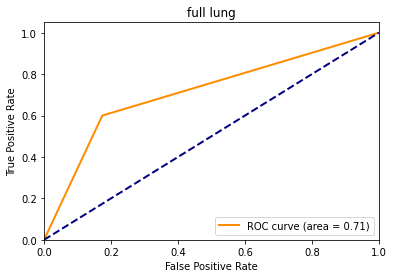

In [17]:
from sklearn.preprocessing import StandardScaler
# print(labl)
# print(out)
import sklearn.metrics as sk
import matplotlib.pyplot as plt
import numpy as np
lablarray=[]
outarray=[]

# print(out)
# print(out[0][:,1])

for i in range(len(out)):
  outarray.append(out[i][:,1])

npout=np.array(outarray).ravel()
print(npout)
prediction_binary = np.where(npout > 0.60,1,0)
print(prediction_binary)

for i in labl:
  lablarray.append(i[0])
  lablarray.append(i[1])
  # lablarray.append(i[2])
  
# # sk.roc_curve(labl,out)
# print(lablarray)
# count=0

# # scaler = StandardScaler()
# # out1=scaler.fit(out)

# # print(out)
# # print(out1)
# # outarray=np.array(out).ravel()
# # out1=np.asarray(outarray)
# for i in out:
#   # print(count)
#   for a in i:
    
#     if lablarray[count]==0:
#       outarray.append(a[0])
#     else:
#       outarray.append(a[1])

#     count +=1
# # xyz=outarray.append(lablarray)
# print(outarray)

fpr = dict()
tpr = dict()
nclass=2 

fpr, tpr, th = sk.roc_curve(np.array(lablarray), prediction_binary)
roc_auc = sk.auc(fpr, tpr)
# print(fpr) 
# print(tpr)
# print(th)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('full lung')
plt.legend(loc="lower right")
plt.show()

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 19 10:49:54 2020

@author: sidhant
"""

import os
import numpy as np
import time
import sys
from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

# from DensenetModels import DenseNet121
# from DensenetModels import DenseNet169
# from DensenetModels import DenseNet201
# from residual_attention_network import ResidualAttentionModel_448concat as ResidualAttentionModelconcat
from residual_attention_network import ResidualAttentionModel_448input as ResidualAttentionModel
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
#-------------------------------------------------------------------------------- 
#---- Class to generate heatmaps (CAM)

class HeatmapGenerator ():
    
    #---- Initialize heatmap generator
    #---- pathModel - path to the trained densenet model
    #---- nnArchitecture - architecture name DENSE-NET121, DENSE-NET169, DENSE-NET201
    #---- nnClassCount - class count, 14 for chxray-14

 
    def __init__ (self, pathModel,nnClassCount, transCrop):
       
        #---- Initialize the network
        # if nnArchitecture == 'DENSE-NET-121': model = DenseNet121(nnClassCount, True).cuda()
        # elif nnArchitecture == 'DENSE-NET-169': model = DenseNet169(nnClassCount, True).cuda()
        # elif nnArchitecture == 'DENSE-NET-201': model = DenseNet201(nnClassCount, True).cuda()
        # model = ResidualAttentionModel()
          
        # model = torch.nn.DataParallel(model).cuda()

        # modelCheckpoint = torch.load(pathModel)
        # model.load_state_dict(modelCheckpoint['state_dict'])

        # self.model = model.module.densenet121.features
        model = ResidualAttentionModel().cuda()
        # model=model.cuda()
        # print(model.features)

        # modelCheckpoint = torch.load(pathModel)
        # print(modelCheckpoint['state_dict'])
        
        model.load_state_dict((torch.load(pathModel)))
        
        # print(model)
        # model.mpool2=Identity()
        # model.fc=Identity()
        # print(model)

        

        self.model = model 
        print(self.model)
        self.model.eval()
        
        #---- Initialize the weights
        
        
        print(list(self.model.residual_block6.conv4.parameters()))
        # print(list(self.model.parameters()))
        self.weights = list(self.model.mpool2[0].parameters())

        #---- Initialize the image transform - resize + normalize
        # normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transformList = []
        transformList.append(transforms.Resize((448,448)))
        transformList.append(transforms.ToTensor())
        # transformList.append(normalize)      
        
        self.transformSequence = transforms.Compose(transformList)
    
    #--------------------------------------------------------------------------------
     
    def generate (self, pathImageFile, pathOutputFile, transCrop):
        
        #---- Load image, transform, convert 
        imageData = Image.open(pathImageFile).convert('RGB')
        imageData = self.transformSequence(imageData)
        imageData = imageData.unsqueeze_(0)
        # left,right=split(imageData)
        
        # leftlung = torch.autograd.Variable(left)
        # rightlung = torch.autograd.Variable(right)
        input = torch.autograd.Variable(imageData)
        
        self.model.cuda()
        output = self.model(input.cuda())
        # print(output.shape)
        # print(self.weights)
        #---- Generate heatmap
        heatmap = None
        for i in range (0, len(self.weights)):
            map = output[0,i]
            if i == 0: heatmap = self.weights[i] * map
            else: heatmap += self.weights[i] * map
        
        #---- Blend original and heatmap 
        print(heatmap)
        npHeatmap = heatmap.cpu().data.numpy()
        print(np.max(npHeatmap))

        imgOriginal = cv2.imread(pathImageFile, 1)
        imgOriginal = cv2.resize(imgOriginal, (448, 448))
        
        cam = npHeatmap / np.max(npHeatmap)
        print(cam)
        # cam = np.squeeze(cam) 
        # plt.imshow(cam)
        
        cam = cv2.resize(cam, (transCrop, transCrop))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        # heatmap=cv2.resize(heatmap,(transCrop, transCrop))      
        img = heatmap * 0.5 + imgOriginal
            
        cv2.imwrite(pathOutputFile, img)
        return img
        
#-------------------------------------------------------------------------------- 

pathInputImage = "/content/drive/My Drive/cropped_images_new/10000984160.png"
pathOutputImage = '/content/drive/My Drive/heatmap.png'
pathModel = "/content/model_448_sgd_full_lungs_85_without_normalization.pkl"

nnArchitecture = ' '
nnClassCount = 2

transCrop = 448
# test_dataset = DatasetGenerator(pathImageDirectory=pathDirDataTest, transform=test_transform)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=2,
#                                           shuffle=False)


h = HeatmapGenerator(pathModel,nnClassCount, transCrop)
heatimg=h.generate(pathInputImage, pathOutputImage, transCrop)


ResidualAttentionModel_448input(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (mpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_block0): ResidualBlock(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias

In [0]:

import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from residual_attention_network import ResidualAttentionModel_92 as ResidualAttentionModel

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        self.model = ResidualAttentionModel().cuda()
        self.model.load_state_dict((torch.load("/content/drive/My Drive/model_92_sgdconcatupdate89.pkl")))

        # self.poollayer=self.model.mpool2
        self.classifier=self.model.fc
        # self.model.mpool2=Identity()
        self.model.fc=Identity()

        self.features_conv = self.model
        
        
        
        
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        print(x.size())
        
        # don't forget the pooling
        # x = self.poollayer(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [0]:
from PIL import Image
net = Net().cuda()
# print(net)

# set the evaluation mode
net.eval()

pathImageFile="/content/drive/My Drive/cropped_images_new/10000984160.png"

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
transformList.append(transforms.Resize((224,224)))
transformList.append(transforms.ToTensor())
transformList.append(normalize)      

transformSequence = transforms.Compose(transformList)


imageData = Image.open(pathImageFile).convert('RGB')
imageData = transformSequence(imageData)
imageData = imageData.unsqueeze_(0)
# input = torch.autograd.Variable(imageData)


# get the most likely prediction of the model
pred = net(imageData.cuda())

print(pred)

pred[:,1].backward()

# pull the gradients out of the model
gradients = net.get_activations_gradient()
print(gradients)

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0,2,3])
pooled_gradient=pooled_gradients.to('cpu').numpy()
# get the activations of the last convolutional layer
activations = net.get_activations(imageData.cuda()).detach()
activation=activations.to('cpu').numpy()
# print(pooled_gradients)
# weight the channels by corresponding gradients
for i in range(2048):
    # print(i)
    activation[0][i] *= pooled_gradient[i]
    
# average the channels of the activations
print(activation)
# heatmap = torch.mean(torch.tensor(activation), dim=1).squeeze()
heatmap=torch.tensor(activation)

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
# heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)
print(heatmap)
# draw the heatmap
plt.matshow(heatmap)


torch.Size([1, 2048])
tensor([[-1.0886,  1.4256]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 0.0214,  0.0173, -0.0232,  ..., -0.0118,  0.0070,  0.0067]],
       device='cuda:0')


IndexError: ignored